### Dynamic Bet Size and Limit Prices

Chapter 3에서 설명한 Triple Barrier Labeling 기법을 기억해 보자. 바 $i$는 시점 $t_{i,0}$에서 형성된 것으로 이때 최초로 달성괼 배리어를 예측한다. 이 예측은 이 예측은 예상된 가격 $E_{t_{i,0}}[p_{t_{i,1}}]$을 암시하고, 이는 배리어의 설정과 일치한다. 결과가 나타날 때까지의 경과 기간 $t \in [t_{i,0}, t_{i,1}]$중에서 가격 $p_t$는 변동을 거듭하고, 이에 따라 추가 예측 $E_{t_{j,0}}[p_{t_{i,1}}]$이 형성될 수도 있다. 여기서 $j \in [i + 1, I]$이고, $t_{j,0} \leq t_{i,1}$이다. 앞서 실행 중인 베팅을 평균화하고, 새로운 예측 형성에 따라 베팅 크기를 이산화하는 방법을 알아봤다. 이번 절에서는 시장 가격 $p_t$와 예측 가격 $f_i$가 변동함에 따라 베팅 크기를 조정하는 방법을 소개한다. 이 과정에서 limit prices를 도출한다.

$q_t$를 현재 포지션, $Q$는 최대 포지션 크기, $\hat{q}_{i,t}$는 예측 $f_i$와 연계된 목표 포지션 크기라고 하면 다음 식을 만족한다.

$$\hat{q}_{i,t} = \text{int}\left[ m [\omega, f_i - p_t]Q\right]$$
$$m[\omega, x] = \frac{x}{\sqrt{\omega + x^2}}$$

여기서 $m[\omega, x]$는 베팅 크기, $x = f_i = p_t$는 현재 시장 가격과 예측 가격 간의 괴리, $\omega$는 sigmoid 함수의 범위를 통제하는 계수, $\text{int}[x]$는 $x$의 정수값이다. 실수값 가격 괴리 $x, -1 < m[\omega, x] < 1$에 대해서, $\hat{q}_{i,t}$의 범위가 $-Q < \hat{q}_{i,t} < Q$로 제한된다는 점에 주목하자. 

목표 포지션 크기 $\hat{q}_{i,t}$는 $p_t$의 변화에 따라 동적으로 조정될 수 있다. 특히 알고리즘은 이익을 실현하려고 하기 때문에 $p_t \rightarrow f_i$가 됨에 따라 $\hat{q}_{i,t} \rightarrow 0$이 된다. 이는 주문 크기 $\hat{q}_{i,t} - q_t$에 대해 손실을 피할 수 있는 손익 분기 지정가는 $\bar{p}$임을 암시한다. 특히

$$\bar{p} = \frac{1}{\vert \hat{q}_{i,t} - q_t \vert} \sum_{j = \left\vert q_t + \text{sgn} \left[ \hat{q}_{i,t} - q_t\right] \right\vert}^{\left \vert \hat{q}_{i,t} \right\vert} L \left[ f_i, \omega, \frac{j}{Q}\right]$$

여기서 $L \left[ f_i, \omega, m\right] = f_i - m\sqrt{\frac{\omega}{1 - m^2}}$는 $p_t$에 대한 $m \left[ \omega, f_i - p_t\right]$의 역함수이다.

$$L \left[ f_i, \omega, m\right] = f_i - m\sqrt{\frac{\omega}{1 - m^2}}$$

$\vert \hat{q}_{i,t} < 1\vert$이기 때문에 $m^2 = 1$에 대해서는 걱정할 필요가 없다. 이 함수는 단조 함수이므로 $p_t \rightarrow f_i$로 됨에 따라 알고리즘은 손실을 실현할 수 없다. 계수 $\omega$의 값을 구해 보자. 주어진 사용자 정의 쌍 $(x, m^*)$에서 $x = f_i = p_t$이고, $m^* = m[\omega, x]$이면 $\omega$에 대한 $m[\omega, x]$의 역함수는 다음과 같다.

$$\omega = x^2 (m^{* -2} - 1)$$

아래의 코드는 동적 포지션 크기와 지정가를 $p_t$와 $f_i$의 함수로 계산하는 알고리즘을 구현한다. 먼저 sigmoid 함수를 조절해 $x = 10$의 가격 괴리에 대해 베팅 크기 $m^* = 0.95$를 도출한다. 둘째, 최대 포지션 $Q = 100, f_i = 115, p_t = 100$에 대해 목표 포지션 $\hat{q}_{i,t}$를 계산한다. $f_i = 110$을 시도하면 계수 $\omega$값과 일치하는 $\hat{q}_{i,t} = 95$를 얻게 된다. 셋째, 주문 크기 $\hat{q}_{i,t} - q_t = 97$인 지정가는 $p_t < 112.3657 < f_i$이고, 이는 현재 가격과 예측 가격 사이에 있다.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sigmoid 함수의 대안으로 power function $\tilde{m}[\omega, x] = \text{sgn}[x][x]^{\omega}$를 사용할 수 있는데, 여기서 $\omega \geq 0, x \in [-1, 1]$이고, 이는 $\tilde{m}[\omega, x] \in [-1, 1]$의 결과를 낸다. 이 대안 방법은 다음과 같은 이점을 가진다.

- $\tilde{m}[\omega, -1] = -1, \tilde{m}[\omega, 1] = 1$
- $\omega$를 사용하면 바로 곡률을 조절할 수 있다
- $\omega > 1$에 대해 함수는 볼록에서 오목이 아니라 오목에서 볼록으로 바뀐다. 그러므로 함수는 굴절 부분에서는 거의 편평하다.

멱함수의 공식을 유도하는 것은 연습 문제로 남겨 둔다. 아래의 그림은 베팅 크기를 가격 과리 $f - p_t$로 각각 sigmoid와 멱함수에 대해 도식화한 것이다.

In [3]:
def f1(x):
    return np.sign(x) * np.abs(x)**2
def f2(x):
    return x * (0.1 + x**2)**(-0.5)

x_values = np.linspace(-1, 1, 500)
y1_values = f1(x_values)
y2_values = f2(x_values)

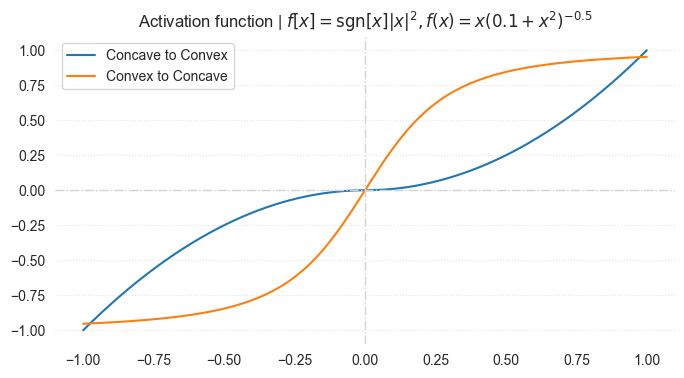

In [9]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(x_values, y1_values, label = 'Concave to Convex')
ax.plot(x_values, y2_values, label = 'Convex to Concave')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.ylim(-1.1, 1.1)
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.legend()
plt.title(r'Activation function | $f[x] = \text{sgn}[x]|x|^2, f(x) = x(0.1 + x^2)^{-0.5}$')
plt.show()